# Extractor.py Notebook


## Functions

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import os
from pyproj import Transformer
from datetime import datetime, timedelta

from helpers import *

from lxml import html
import requests

start_date = datetime(1950, 1, 1) 

In [2]:
def checkDates(time1,time2):
    time_start = datetime(int(time1[:4]), int(time1[4:6]), int(time1[6:]))
    time_end = datetime(int(time2[:4]), int(time2[4:6]), int(time2[6:]))
    assert time_start < time_end, 'ERROR: time1 cannot be after time2, please check.'
    
    year1 = int(time1[:4])
    year2 = int(time2[:4])
    time_str = f'{time1}-{time2}'
    
    years = list(np.arange(year1,year2+1))
    
    return time_start, time_end, year1, year2, time_str, years

In [3]:
def checkParams(depth, bbox, time1, time2, vars_sel, group, formats):
    # Define Global Variables
    global time_start, time_end, time_str, year1, year2, years, bbox_g, bbox_str, depth_g, vars_g, group_g, formats_g
     
    # Check dates
    time_start, time_end, year1, year2, time_str, years = checkDates(time1,time2)
    print('Time Range:', time_str)
    print('Years of data:', years)

    # Check BBOX
    bbox_g = [int(bb) for bb in bbox.split(',')]
    bbox_str = '.'.join([str(b) for b in bbox_g])
    print('Bounding Box:', bbox_g) #, bbox_str)

    # Check depth
    depth_g = depth
    print(f'Depth: {depth_g}m')

    # Check Vars
    vars_g = vars_sel.split(',')
    print('Vars:', vars_g)

    # Check 'group' flag
    if len(vars_g) > 1:
        # the flag 'group' is required in this case
        group_g = group
        assert group_g is not None, 'The flag "--group" is required when multiple variables are selected.'
        print('Group files per Var:', group_g)

    else: group = False
    
    # Check Formats
    formats = [ff.lower() for ff in formats.split(',')]    
    formats_g = []
    if 'csv' in formats: formats_g.append('CSV')
    if 'netcdf4' in formats: formats_g.append('NetCDF4')
    print('Output files format(s):', formats_g)
    assert len(formats_g) > 0, 'ERROR: Output file format entered is wrong. It must be "csv", "netcdf4", or "csv,netcdf4".'

In [4]:
def getDDS(url_info, year):
    # Get dds info, and assign max dimensions to TIME and DEPTH
    
    pc_dim_dict = {}
    time_stop_dict = {}
    depth_stop_dict = {}

    # get all content of the server_url, and then filter it with year and available platforms
    page = requests.get(url_info[0])
    webpage = html.fromstring(page.content)
    
    urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(f'{year}.nc{url_info[1]}.dds')]

    for u in urls_filtered:

        dds = f'{url_info[0]}/{u}'#; print(dds)

        # Find platform code
        if len(url_info[1]) == 0: pc = dds.split('_')[0][-2:] # nmdc case
        else: pc = dds.split('_')[1][-2:] # t2_hyrax case

        pc_dim_dict[pc] = retrieveDDSinfo(dds)

        time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
        depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

    assert depth_stop_dict.keys() == time_stop_dict.keys(), 'TIME and DEPTH Keys error. Please check.'
    
    return pc_dim_dict


In [5]:
def getPositionDict(pc_dim_dict, url_info, year):
    # Extract data and create position_dict
    
    position_dict = {}
    
    for pc in pc_dim_dict.keys():

        coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) 

        fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign

        url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)

        remote_data, data_attr = fetch_data(url, year)

        position_dict[pc] = {'data': remote_data, 
                             'data_attr': data_attr}
#     print(position_dict)    
    
    return position_dict


In [6]:
def makePositionDF(position_dict):
    # Load locations (LONG & LAT) and TIME of all measurements in a position_df_raw (includes duplicates)

    position_df_raw = pd.DataFrame() 

    for key in position_dict.keys():
        test = pd.DataFrame()
    
        test['Longitude_WGS84'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
        test['Latitude_WGS84'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
        test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
        test['Platform'] = key

        # Convert TIME from float to datetime
        test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
        length = len(test[test['Platform']==key])
        print(f'Platform {key}: {length} measurement locations.')
        
        position_df_raw = position_df_raw.append(test) 
        
    position_df_raw['Index_ABS'] = np.arange(0,len(position_df_raw))
    position_df_raw = position_df_raw.rename_axis("Index_Relative")
    
    # Now remove duplicates
    duplicates = position_df_raw[position_df_raw.duplicated(subset='Time') == True]
    
    position_df_temp = position_df_raw.drop_duplicates(subset=['Time'])
    
    print(f'Merged dataframe with all platforms. Total of {len(position_df_raw)} measurement positions')
    print(f'Duplicates: \t{len(duplicates)} / {len(position_df_raw)} \nRemaining: \t{len(position_df_temp)} / {len(position_df_raw)}')

    return position_df_temp

In [7]:
def filterBBOXandTIME(position_df, time1, time2):
    # Filter the position_df dataframe by BBOX
    position_df_bbox = position_df[(position_df.loc[:,'Longitude_WGS84'] >= bbox_g[0]) & 
                                   (position_df.loc[:,'Longitude_WGS84'] <= bbox_g[1]) & 
                                   (position_df.loc[:,'Latitude_WGS84'] >= bbox_g[2]) & 
                                   (position_df.loc[:,'Latitude_WGS84'] <= bbox_g[3])]

    # Print filtering results on original dataframe
    global sel_outof_all
    sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
#     print(f'Selected positions (out of available positions): {sel_outof_all}')
#     print(position_df_bbox)

    # Filter the position_df_bbox dataframe by TIME
    position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                      (position_df_bbox['Time']<=time_end)]

    # Print filtering results on original dataframe
    print(f'\nUser-defined Time Range: {time_str}')
    sel_outof_all = f'{len(position_df_bbox_timerange)} out of {len(position_df)}.'
    print(f'Selected positions (out of available positions): {sel_outof_all}')

    # print(position_df_bbox_timerange)
    
    return position_df_bbox_timerange


In [8]:
def getIndices(df_filtered):
    index_dict = {}
    
    for pc in df_filtered['Platform'].unique():
        index_dict[pc] = df_filtered[df_filtered['Platform']==pc].index.tolist()
    
    return index_dict

In [9]:
def extractVARsAndDepth(pc_sel, position_dict, pc_dim_dict, url_info, year):  
    data_dict = {}
    metadata = {}

    for pc in pc_sel:
        print(pc)
        metadata[pc] = {}

        v_min = int(float(position_dict[pc]['data_attr'][6]))
        metadata[pc]['vmin'] = v_min
        metadata[pc]['depth_abs_v1'] = 0 # this is fixed
        metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed

        # ==============================================================================
        """
        Define here the DEPTH range of your selection, in meters. Note that either:
        - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
        - 'depth_m_v2' is equal to the upper bound (ie index=-1)
        """
        metadata[pc]['depth_m_v1'] = 0 
        metadata[pc]['depth_m_v2'] = depth_g
        # ==============================================================================

        # assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
        # assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'

        #     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')

        # the start and stop values are adjusted based on the vmin value
        if metadata[pc]['vmin'] == 1: 
            if metadata[pc]['depth_m_v1'] == 0: # 
                metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
                metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
                metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1

            elif metadata[pc]['depth_m_v1'] != 0: 
                metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
                metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
                metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 

        else:
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']

            if metadata[pc]['depth_m_v1'] == 0: # 
                metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

            elif metadata[pc]['depth_m_v1'] != 0: 
                metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']

        metadata[pc]['depth_newindex4xr_v1'] = 0

        pprint.pprint(metadata[pc])
        print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')

        fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

        # Get coordinates (needed for keeping the correct structure, and for plotting) 
        coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want

        # Extract TIME and DEPTH dimension for queries 
        time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
        depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)

        # join TIME and DEPTH for Variables
        var_str_ALL = []
        for v in vars_g: var_str_ALL = np.append(var_str_ALL, f'{v}{time_dims}{depth_dims}')
        queries_vars = ','.join(var_str_ALL)

        # Build url and url with queries (url_q)
        url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}' 
        url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)

        remote_data, data_attr = fetch_data(url_q, year)

        data_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}

        print(f'{data_attr}\n')
    
    assert list(pc_sel) == list(data_dict.keys()), 'ERROR: different platforms, please check.'
    
    return data_dict, metadata


In [10]:
# Function to save Attributes to a database
def getAttributes(my_df, my_dict):
    
    for key in my_dict.keys():

        my_df.loc[key,'Platform_code'] = [my_dict[key]['data_attr'][0].astype(str)]
        my_df.loc[key,'Platform_name'] = [my_dict[key]['data_attr'][1].astype(str)]
        my_df.loc[key,'Year'] = [my_dict[key]['data_attr'][2].astype(int)]
        my_df.loc[key,'Data_type'] = [my_dict[key]['data_attr'][3].astype(str)]
        my_df.loc[key,'Title'] = [my_dict[key]['data_attr'][4].astype(str)]
        my_df.loc[key,'Instrument'] = [my_dict[key]['data_attr'][5].astype(str)]
        my_df.loc[key,'Vertical_min'] = [my_dict[key]['data_attr'][6].astype(float)]
        my_df.loc[key,'Vertical_max'] = [my_dict[key]['data_attr'][7].astype(float)]
        my_df.loc[key,'Lon_min'] = [my_dict[key]['data_attr'][8].astype(float)]
        my_df.loc[key,'Lon_max'] = [my_dict[key]['data_attr'][9].astype(float)]
        my_df.loc[key,'Lat_min'] = [my_dict[key]['data_attr'][10].astype(float)]
        my_df.loc[key,'Lat_max'] = [my_dict[key]['data_attr'][11].astype(float)]

    return my_df    

In [11]:
def getVminDict(overview_df):
    vmin_dict = {}

    # select only those platforms where vmin == 1
    vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

    for i in vmin_pc:
        vmin_dict[i] = {}

        for v in vars_g:
            vmin_dict[i][v] = False
    
    return vmin_dict


In [12]:
# Function to check whether data should be aligned if vmin = 1, and align if so if has not been done already
def check_alignment(data_dict, pc, var, align_and_nan, vmin_dict):
    
    xarr = data_dict[pc]['data']
    xarr_var = xarr[var].data
    
    vmin = float(xarr.attrs['geospatial_vertical_min'])

    if vmin == 0:
        print(f'Platform: {pc}; Vertical min: {vmin}; Var: {var}')
        
    elif vmin==1 and vmin_dict[pc][var]==False and align_and_nan: 
        # shift to the right and add nan in first position 
        print(f'Platform: {pc}; Vertical min: {vmin}; Var: {var} --> aligning and add nan')        
        data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
        vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once  
        
    elif vmin==1 and vmin_dict[pc][var]==False and not align_and_nan: 
        # No need to shift, this occurred already in the data extraction
        print(f'Platform: {pc}; Vertical min: {vmin}; Var: {var} --> data has been aligned already')
        vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once
    
    
#     return data_dict[pc], vmin_dict[pc][var]

In [13]:
def filterbyDepthAndIndices(data_dict_yr, metadata_yr, vmin_dict_yr, df_filtered):
    
    print(f'Selected DEPTH: {depth_g}m')
    
    for year in data_dict_yr.keys():
        print(year)
        filtered_xarr_dict[year] = {}
        
        # Select available platforms ONLY of the specific year
        df_year = df_filtered[pd.DatetimeIndex(df_filtered['Time']).year == year] # select only those rows of that year
        pc_year = df_year['Platform'].unique()

        for pc in pc_year:
            print(pc)
            # Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
            
            if metadata_yr[year][pc]['depth_m_v1']==0: align_and_nan = True
            else: align_and_nan = False

            for v in vars_g: 
                check_alignment(data_dict_yr[year], pc, v, align_and_nan, vmin_dict_yr[year]) 

            filtered_xarr_dict[year][pc] = filter_xarr_DEPTH(df_filtered, 
                                                             data_dict_yr[year],
                                                             platform=pc,
                                                             depth_range=[depth_g, depth_g])
            display(filtered_xarr_dict[year][pc])
        print('\n')
    
    return filtered_xarr_dict

In [14]:
# Function to filter XARRAY based on platform, Var and DEPTH
def filter_xarr_DEPTH(df_toPlot, data_dict, platform, depth_range):
   
    # find indices for each platform for the selected data
    index = df_toPlot[df_toPlot['Platform']==platform].index.tolist()
        
    # Filer data using the indexes of the filtered elements
    xarr_sel = data_dict[platform]['data'].isel(TIME=index,
                                                LATITUDE=index,
                                                LONGITUDE=index,
                                                DEPTH=slice(depth_range[0], depth_range[1]+1))
    return xarr_sel

In [15]:
def aggregatePlatforms(filtered_xarr_dict, year):
    # Dictionary of variables for each platform
    depth_arr = []

    for year in years:
        print(year)
        data_var_dict_yr[year] = {}

        for pc in filtered_xarr_dict[year].keys():

            data_var_dict_yr[year][pc] = {}
            data = filtered_xarr_dict[year][pc]

            depth_dim_pc = data.dims["DEPTH"]
            depth_arr.append(depth_dim_pc)

            print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')

            for var in vars_g:
                data_var_dict_yr[year][pc][var] = filtered_xarr_dict[year][pc][var]

        assert all(x==depth_arr[0] for x in depth_arr), 'ERROR, the DEPTH dimensions must be equal.'
        #display(data_var_dict_yr[year])
        
    return data_var_dict_yr

In [16]:
# Function to plot a specific variable across the merged platforms
def plotVar_MergedPlatforms(merged_arr_var, var, title):
    plt.figure()
    merged_arr_var[var].plot() 
    plt.title(title)

In [17]:
def mergeArrays(data_var_dict_yr):
    # Combine arrays across platforms, for each variable
        
    for var in vars_g:

        merged_arr[var] = xr.merge([data_var_dict_yr[y][pc][var] for y in data_var_dict_yr.keys() for pc in data_var_dict_yr[y].keys()] )  
        
        title = f'Var={var} (Merged Platforms)\nFilter: Time Range={time_str};\nBBOX={bbox_g}; Depth {depth}m;\nSel/All={sel_outof_all}'

        plotVar_MergedPlatforms(merged_arr[var], var, title=title)
    
    return merged_arr

## Set-up

### Input Params

In [18]:
depth = 25
bbox = "-20, 40, 50, 85"
time1 = '20031201' 
time2 = '20031231' #'20040131' 
vars_sel = 'TEMP'
formats = 'csv'
group = False

checkParams(depth, bbox, time1, time2, vars_sel, group, formats)

Time Range: 20031201-20031231
Years of data: [2003]
Bounding Box: [-20, 40, 50, 85]
Depth: 25m
Vars: ['TEMP']
Output files format(s): ['CSV']


### Server URL

In [19]:
# URL of Norwegian Marine Data Centre (NMDC) data server
nmdc_url = 'http://opendap1.nodc.no/opendap/physics/point/yearly/' 

# URL of Terradue Cloud Platform Hyrax server
# Ellip user account and VPN setup required
t2_hyrax_url = 'https://opendap.terradue.com/hyrax/data/subset_2003/'

urls = {}
urls['nmdc'] = [nmdc_url, '']
urls['t2_hyrax'] = [t2_hyrax_url, '.nc4']

#========================================================
# Define below the URL to use (either 'nmdc' or 't2_hyrax'):
url_info = urls['nmdc']
#========================================================

print('Server URL and URL suffix:', url_info)

Server URL and URL suffix: ['http://opendap1.nodc.no/opendap/physics/point/yearly/', '']


## Extraction of NetCDF data

In [20]:
dds_year_dict = {}
pos_year_dict = {}
global position_df
position_df = pd.DataFrame()

for year in range(year1, year2+1): # need to do a for loop over the years as the data is saved in years on the server
    print('\nWorking on year:', year)
    
    # Retrieval of DDS info
    dds_year_dict[year] = getDDS(url_info, year) # dds_year_dict[year] replaced pc_dim_dict 
    pprint.pprint(dds_year_dict[year])
    
    # Extract all platform_codes for that year
    platform_codes = [pc for pc in dds_year_dict[year].keys()]
    print(f'Available platforms in given year {year}: {platform_codes}')

    # Create position_dict
    pos_year_dict[year] = getPositionDict(dds_year_dict[year], url_info, year) # pos_year_dict[year] replaced position_dict
#     pprint.pprint(pos_year_dict[year])

    # Match and merge LAT, LONG and TIME of positions in a position_df dataframe
    print('Now makePositionDF')
    position_df_temp = makePositionDF(pos_year_dict[year])
    
    position_df = position_df.append(position_df_temp)
    display(position_df)

print('COMBINED position_df')
display(position_df) 


Working on year: 2003
{'AA': {'DEPTH': 2809, 'LATITUDE': 683, 'LONGITUDE': 683, 'TIME': 683},
 'GS': {'DEPTH': 3683, 'LATITUDE': 404, 'LONGITUDE': 404, 'TIME': 404},
 'GT': {'DEPTH': 2956, 'LATITUDE': 990, 'LONGITUDE': 990, 'TIME': 990},
 'HJ': {'DEPTH': 789, 'LATITUDE': 178, 'LONGITUDE': 178, 'TIME': 178},
 'JH': {'DEPTH': 3763, 'LATITUDE': 949, 'LONGITUDE': 949, 'TIME': 949}}
Available platforms in given year 2003: ['AA', 'GS', 'GT', 'HJ', 'JH']
Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GT_CTD_2003.nc?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58H

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


COMBINED position_df


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


## Filtering by BBOX and Time

In [21]:
# Filter by BBOX and Time
df_filtered = filterBBOXandTIME(position_df, time1, time2)
display(df_filtered)

 # Dictionary of indices
index_dict = getIndices(df_filtered)
pprint.pprint(index_dict)


User-defined Time Range: 20031201-20031231
Selected positions (out of available positions): 88 out of 3209.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
647,5.0987,61.916801,2003-12-01 06:06:42,AA,647
648,5.3507,62.132198,2003-12-01 15:04:22,AA,648
649,5.4582,62.091702,2003-12-01 16:25:02,AA,649
650,5.5118,62.060001,2003-12-01 17:00:58,AA,650
651,5.5007,62.035301,2003-12-01 17:28:26,AA,651
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


{'AA': [647,
        648,
        649,
        650,
        651,
        652,
        653,
        654,
        655,
        656,
        657,
        658,
        659,
        660,
        661,
        662,
        663,
        664,
        665,
        666,
        667,
        668,
        669,
        670,
        671,
        672,
        673,
        674,
        675,
        676,
        677,
        678,
        679,
        680,
        681,
        682,
        683],
 'GS': [379,
        380,
        381,
        382,
        383,
        384,
        385,
        386,
        387,
        388,
        389,
        390,
        391,
        392,
        393,
        394,
        395,
        396,
        397,
        398,
        399,
        400,
        401,
        402,
        403,
        404],
 'JH': [925,
        926,
        927,
        928,
        929,
        930,
        931,
        932,
        933,
        934,
        935,
        936,
        937,
        93

## Data Processing: Load and Plot selected Data (Variables within DEPTH range)

### Fetch data per year

In [22]:
df_filtered

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
647,5.0987,61.916801,2003-12-01 06:06:42,AA,647
648,5.3507,62.132198,2003-12-01 15:04:22,AA,648
649,5.4582,62.091702,2003-12-01 16:25:02,AA,649
650,5.5118,62.060001,2003-12-01 17:00:58,AA,650
651,5.5007,62.035301,2003-12-01 17:28:26,AA,651
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


In [23]:
global data_dict_yr, metadata_yr, vmin_dict_yr, filtered_xarr_dict
data_dict_yr = {}
metadata_yr = {}
vmin_dict_yr = {}

for year in range(year1, year2+1): # need to do a for loop over the years as the data is saved in years on the server
    
    # Extract all platform_codes for that year, given the BBOX and time constraints
    df_year = df_filtered[pd.DatetimeIndex(df_filtered['Time']).year == year] # select only those rows of that year
    pc_sel = df_year['Platform'].unique()
    print(f'Working on year: {year} - Available platforms: {pc_sel}')

    data_dict_yr[year], metadata_yr[year] = extractVARsAndDepth(pc_sel, pos_year_dict[year], dds_year_dict[year], url_info, year) 

    print(f'Attributes Year: {year}')
    # Create overview dataframe
    overview_df = pd.DataFrame()
    overview_df = getAttributes(overview_df, data_dict_yr[year])
    print('overview_df')
    display(overview_df)

    # Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
    vmin_dict_yr[year] = getVminDict(overview_df)
    
# print('\n2) ===================Printing Results:')
# print('\n2.1) data_dict_yr')
# pprint.pprint(data_dict_yr)
# print('\n2.2) metadata_yr')
# pprint.pprint(metadata_yr)
# print('\n2.3) vmin_dict_yr')
# pprint.pprint(vmin_dict_yr)

Working on year: 2003 - Available platforms: ['AA' 'GS' 'JH']
AA
{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 0,
 'depth_m_v2': 25,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 25,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 25,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 0 - 25
Platform AA URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][0:1:25]
['58AA' 'H\\303\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

GS
{'depth_abs_v1': 0,
 'depth_abs_v2': 3683,
 'depth_m_v1': 0,
 'depth_m_v2': 25,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 25,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 25,
 'vmin': 1}
GS DEPTH range of interest (adjusted with vmin): 0 - 25
Platform GS URL: http://opendap1.nodc.no/opendap/physics/point/yearly/

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\303\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
JH,58JH,Johan Hjort,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3766.0,-15.502,47.017,50.998,77.829


### Filter by Depth and Indices (generated by BBOX and Time indices)  

In [24]:
# Filter by Depth and Indices (generated by BBOX and Time indices) 
filtered_xarr_dict = {}
filtered_xarr_dict = filterbyDepthAndIndices(data_dict_yr, metadata_yr, vmin_dict_yr, df_filtered)
display(filtered_xarr_dict)

Selected DEPTH: 25m
2003
AA
Platform: AA; Vertical min: 0.0; Var: TEMP


<xarray.Dataset>
Dimensions:    (TIME: 37, LATITUDE: 37, LONGITUDE: 37, DEPTH: 1)
Coordinates:
  * TIME       (TIME) float64 1.969e+04 1.969e+04 ... 1.97e+04 1.97e+04
  * LATITUDE   (LATITUDE) float32 61.92 62.13 62.09 62.06 ... 63.53 63.59 63.92
  * LONGITUDE  (LONGITUDE) float32 5.099 5.351 5.458 5.512 ... 10.36 10.9 11.04
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 9.246 9.844 9.975 ... 8.011 7.109 7.822
Attributes: (12/152)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_DM._FillValue:              
    CNDC_DM.conventions:            Copernicus Marine In Situ reference table 1
    CNDC_DM.flag_values:            R, A, D
    CNDC_DM.flag_meanings:          real-time adjusted-in-real-time delayed-mode
    CNDC_DM.long_name:              Electrical conductivity method of data pr...
    CNDC_DM.string_length:          2810

GS
Platform: GS; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (TIME: 26, LATITUDE: 26, LONGITUDE: 26, DEPTH: 1)
Coordinates:
  * TIME       (TIME) float64 1.969e+04 1.969e+04 ... 1.97e+04 1.97e+04
  * LATITUDE   (LATITUDE) float32 68.46 68.39 68.36 68.37 ... 68.37 68.38 68.38
  * LONGITUDE  (LONGITUDE) float32 17.59 16.97 16.9 16.95 ... 16.09 16.09 16.09
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 7.742 7.201 7.399 ... 6.686 6.926 7.247
Attributes: (12/128)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

JH
Platform: JH; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (TIME: 25, LATITUDE: 25, LONGITUDE: 25, DEPTH: 1)
Coordinates:
  * TIME       (TIME) float64 1.97e+04 1.97e+04 1.97e+04 ... 1.971e+04 1.971e+04
  * LATITUDE   (LATITUDE) float32 69.28 69.71 69.77 70.26 ... 71.75 71.74 71.75
  * LONGITUDE  (LONGITUDE) float32 14.13 14.03 15.53 15.46 ... 13.01 14.99 17.07
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 8.066 8.065 7.451 ... 5.978 6.756 7.259
Attributes: (12/128)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

{2003: {'AA': <xarray.Dataset>
  Dimensions:    (TIME: 37, LATITUDE: 37, LONGITUDE: 37, DEPTH: 1)
  Coordinates:
    * TIME       (TIME) float64 1.969e+04 1.969e+04 ... 1.97e+04 1.97e+04
    * LATITUDE   (LATITUDE) float32 61.92 62.13 62.09 62.06 ... 63.53 63.59 63.92
    * LONGITUDE  (LONGITUDE) float32 5.099 5.351 5.458 5.512 ... 10.36 10.9 11.04
  Dimensions without coordinates: DEPTH
  Data variables:
      TEMP       (TIME, DEPTH) float64 9.246 9.844 9.975 ... 8.011 7.109 7.822
  Attributes: (12/152)
      _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
      title:                          Arctic Ocean - In Situ Observation Copern...
      qc_manual:                      Recommendations for in-situ data Near Rea...
      contact:                        cmems-service@imr.no
      format_version:                 1.4
      distribution_statement:         These data follow Copernicus standards; t...
      ...                             ...
      CNDC_DM.

### Aggregation of available platforms

In [25]:
data_var_dict_yr = {}
data_var_dict_yr = aggregatePlatforms(filtered_xarr_dict, year)
display(data_var_dict_yr[year])

2003
PC AA	Filtered Dims: TIME=37, DEPTH=1
PC GS	Filtered Dims: TIME=26, DEPTH=1
PC JH	Filtered Dims: TIME=25, DEPTH=1


{'AA': {'TEMP': <xarray.DataArray 'TEMP' (TIME: 37, DEPTH: 1)>
  array([[ 9.246],
         [ 9.844],
         [ 9.975],
         [10.445],
         [10.598],
         [10.516],
         [10.704],
         [10.779],
         [10.946],
         [ 9.769],
         [ 9.97 ],
         [ 9.554],
         [ 9.423],
         [ 9.206],
         [ 9.49 ],
         [10.04 ],
         [ 9.895],
         [ 9.919],
         [ 9.082],
         [ 9.392],
         [ 8.743],
         [ 9.741],
         [ 9.816],
         [ 9.063],
         [ 8.646],
         [ 8.603],
         [ 8.671],
         [ 8.786],
         [ 8.745],
         [ 8.71 ],
         [ 8.695],
         [ 8.113],
         [ 8.312],
         [ 7.178],
         [ 8.011],
         [ 7.109],
         [ 7.822]])
  Coordinates:
    * TIME     (TIME) float64 1.969e+04 1.969e+04 1.969e+04 ... 1.97e+04 1.97e+04
  Dimensions without coordinates: DEPTH
  Attributes:
      standard_name:        sea_water_temperature
      long_name:            Sea 

### Combine Arrays across platforms and years 
Now aggregate and plot each variable: on the y-axis is shown the TIME of the measurement (in float format, which needs to be converted to datetime format), and on the x-axis is the DEPTH of the measurement.

In [26]:
# data_var_dict_yr

<xarray.Dataset>
Dimensions:  (TIME: 88, DEPTH: 1)
Coordinates:
  * TIME     (TIME) float64 1.969e+04 1.969e+04 ... 1.971e+04 1.971e+04
Dimensions without coordinates: DEPTH
Data variables:
    TEMP     (TIME, DEPTH) float64 9.246 9.844 9.975 10.45 ... 5.978 6.756 7.259
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            M

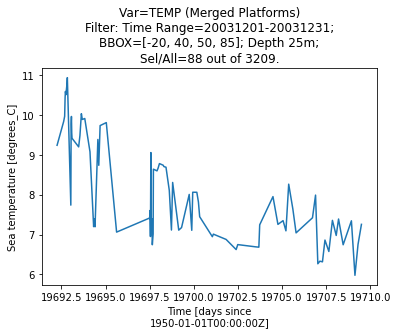

In [27]:
merged_arr = {}
merged_arr = mergeArrays(data_var_dict_yr)
merged_arr['TEMP']

#### Print or Export Filtered Positions
Uncomment the rows below if you want to display or export to CSV the filtered dataframe.

In [ ]:
# # Print filtered dataframe
# pd.set_option('display.max_rows', None) # pd.set_option('display.max_rows', 10) # to restore first- and last- 5 rows to display
# display(position_df_bbox_timerange)

# # Save dataframe to csv
# data_output = os.path.join(os.getcwd(), 'data_output')
# if not os.path.exists(data_output): os.mkdir(data_output)
# csvname = os.path.join(data_output, f'filtered_{pc}_df.csv')
# position_df_bbox_timerange.to_csv(csvname, sep=',', header=True)

In [ ]:
stop

### Export to File

In [ ]:
# Output dir
data_output = os.path.join(os.getcwd(), 'data_output')
if not os.path.exists(data_output): os.mkdir(data_output)

# File name (without file extension)
fname = os.path.join(data_output, 
                     f'Scientist_pc={pc_str}_BBOX={bbox_key}_MMYYYY={time_filter_str}_d={depth1}-{depth2}m_var={"_".join(vars_sel)}')

#### Export to NetCDF

In [ ]:
# Export to NetCDF
netcdfname = fname + '.nc.nc4'
merged_arr['TEMP'].to_netcdf(path=netcdfname,
                             mode='w')

#### Export to CSV
##### Create Dataframe of Filtered XARRAY
This step is implemented to generate a CSV-structured dataframe, to then export to a CSV file, which is the input expected by the RGeostats module.

In [ ]:
# Create dataframe with filtered data and columns ['LATITUDE', 'LONGITUDE', 'TIME', 'TEMP', 'DEPTH']
filtered2csv_multiDepths = pd.DataFrame() 

for pc in data_dict.keys():

    for d in range(depth1, depth2+1):

        # Create temporary dataframe
        temp = pd.DataFrame()

        data_depth_sel = data_dict[pc]['data'].isel(TIME=index_dict[pc],
                                                    LATITUDE=index_dict[pc],
                                                    LONGITUDE=index_dict[pc],
                                                    DEPTH=slice(d, d+1))

        for col in ['LONGITUDE', 'LATITUDE', 'TIME']:
            temp[col.title()] = data_depth_sel[col].data.astype(float) 

        if 'TEMP' in vars_sel: temp['Temperature'] = data_depth_sel['TEMP'].data.astype(float) 
        if 'CNDC' in vars_sel: temp['Conductivity'] = data_depth_sel['CNDC'].data.astype(float) 
        if 'PSAL' in vars_sel: temp['Salinity'] = data_depth_sel['PSAL'].data.astype(float) 

        temp['Depth'] = d 
        temp['Vessel_name'] = pc 

        filtered2csv_multiDepths = filtered2csv_multiDepths.append(temp, ignore_index=True)
    
# Rename index column with 'rank'
filtered2csv_multiDepths = filtered2csv_multiDepths.rename_axis("rank")

display(filtered2csv_multiDepths)

##### Assign *Profil_id* to the unique positions

In [ ]:
# find pair of unique coordinates 
unique_pos = filtered2csv_multiDepths.groupby(['Longitude','Latitude']).size().reset_index().rename(columns={0:'count'})

prof_id = 1
for long, lat in zip(unique_pos['Longitude'], unique_pos['Latitude']):
    
    # Define condition
    cond = (filtered2csv_multiDepths['Longitude'] == long) & (filtered2csv_multiDepths['Latitude'] == lat)
#     display(filtered2csv_multiDepths.loc[cond])
    
    # Assign unique Profil_id 
    filtered2csv_multiDepths.loc[cond,'Profil_id'] = prof_id
    prof_id += 1

# Convert to integer
filtered2csv_multiDepths = filtered2csv_multiDepths.astype({'Profil_id': int})
display(filtered2csv_multiDepths)

In [ ]:
# Export dataframe to CSV
csvname = fname + '.csv'
filtered2csv_multiDepths.to_csv(csvname, sep=',', header=True)
print('Output filename:', csvname)